<a href="https://colab.research.google.com/github/xellnaga/google_colab/blob/main/selenium.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#구글 이미지 스크래핑

## Selenium 및 웹 드라이버 설치

In [22]:
!pip install Selenium
!apt-get update
!apt install chromium-chromedriver
!cp /usr/lib/chromium-browser/chromedriver /usr/bin

import sys
sys.path.insert(0, '/usr/lib/chromium-broser/chromedriver')

from selenium import webdriver
chrome_options = webdriver.ChromeOptions()
chrome_options.add_argument('--headless')
chrome_options.add_argument('--no-sandbox')
chrome_options.add_argument('--disable-dev-shm-usage')

wd = webdriver.Chrome('chromedriver', options=chrome_options)

Ign:1 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  InRelease
Ign:2 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  InRelease
Hit:3 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu1804/x86_64  Release
Hit:4 https://cloud.r-project.org/bin/linux/ubuntu bionic-cran40/ InRelease
Hit:5 https://developer.download.nvidia.com/compute/machine-learning/repos/ubuntu1804/x86_64  Release
Hit:7 http://security.ubuntu.com/ubuntu bionic-security InRelease
Hit:8 http://ppa.launchpad.net/c2d4u.team/c2d4u4.0+/ubuntu bionic InRelease
Hit:9 http://archive.ubuntu.com/ubuntu bionic InRelease
Hit:10 http://archive.ubuntu.com/ubuntu bionic-updates InRelease
Hit:12 http://archive.ubuntu.com/ubuntu bionic-backports InRelease
Hit:13 http://ppa.launchpad.net/cran/libgit2/ubuntu bionic InRelease
Hit:14 http://ppa.launchpad.net/deadsnakes/ppa/ubuntu bionic InRelease
Hit:15 http://ppa.launchpad.net/graphics-drivers/ppa/ubuntu bionic

## 라이브러리 import

In [23]:
import os
import time
import socket

from urllib.request import urlretrieve
from urllib.error import HTTPError, URLError
from selenium.common.exceptions import ElementClickInterceptedException, NoSuchElementException, ElementNotInteractableException
from PIL import Image

## 'scroll_down()' : 스크롤을 내리는 함수

In [36]:
def scroll_down():
  scroll_count = 0
  print("[scroll_down() : 스크롤 다운 시작]")
  
  last_height = wd.execute_script("return document.body.scrollHeight")
  after_click = False
  while True:
    print(f"[스크롤 다운: {scroll_count}]")
    wd.execute_script("window.scrollTo(0, document.body.scrollHeight);")
    scroll_count += 1
    time.sleep(1)

    new_height = wd.execute_script("return document.body.scrollHeight")

    if last_height == new_height:
      if after_click is True:
        break
      else:
        try:
          more_button = wd.find_element_by_xpath('//*[@id="islmp"]/div/div/div/div/div[3]/div[2]/input')
          if more_button.is_displayed():
            more_button.click()
            after_click = True
        except NoSuchElementException as e:
          print(e)
          break
    last_height = new_height



##'click_and_save()' : 썸네일 이미지 선택 후 원본 이미지 저장

In [50]:
def click_and_save(dir_name, index, img, img_list_length):
  global scraped_count
  
  try:
    img.click()
    wd.implicitly_wait(3)
    src  = wd.find_element_by_xpath('//*[@id="Sva75c"]/div/div/div[3]/div[2]/c-wiz/div/div[1]/div[1]/div/div[2]/a/img').get_attribute('src')
    if src.split('.')[-1] == 'png':
      urlretrieve(src,dir_name + '/' + str(scraped_count + 1)+".png")
      print(f"{index+1}/{img_list_length} PNG 이미지 저장")
    else:
      urlretrieve(src,dir_name + '/' + str(scraped_count + 1)+".jpg")
      print(f"{index+1}/{img_list_length} JPG 이미지 저장")

    scraped_count += 1

  except HTTPError as e:
    print(e)
    pass
  except ElementClickInterceptedException as e:
    print(e)
    pass

## 'scraping()' : 구글 이미지 스크래핑 함수

In [64]:
def scraping(dir_name, query):
  global scraped_count

  url = f"https://www.google.com/search?q={query}&tbm=isch&tbs=isz:l&hl=ko&sa=X&ved=0CAEQpwVqFwoTCJCaqKLo4_ACFQAAAAAdAAAAABAC&biw=1820&bih=942"
  print(url)
  wd.get(url)
  wd.maximize_window()

  scroll_down()
  div = wd.find_element_by_xpath('//*[@id="islrg"]/div[1]')
  print(div)
  img_list = div.find_elements_by_css_selector('div.bRMDJf.islir > img')
  print(img_list)
  for index, img in enumerate(img_list):
    try:
      click_and_save(dir_name, index, img, len(img_list))
    except ElementClickInterceptedException as e:
      print(e)
      wd.execute_script("window.scrollTo(0, window.scrollY + 100")
      time.sleep(1)
      click_and_save(dir_name, index, img, len(img_list))
    except NoSuchElementException as e:
      print(e)
      wd.execute_script("window.scrollTo(0, window.scrollY + 100")
      time.sleep(1)
      click_and_save(dir_name, index, img, len(img_list))
    except ConnectionResetError as e:
      print(e)
      pass
    except URLError as e:
      print(e)
      pass
    except socket.timeout as e:
      print(e)
      pass
    except socket.gaierror as e:
      print(e)
      pass
    except ElementNotInteractableException as e:
      print(e)
      break
  try:
    print("[스크래핑 종료 (성공률: %.2f%%)]" % (scraped_count /len(img_list) * 100.0))
  except ZeroDivisionError as e:
    print(e)
  
  wd.quit()


## 'filter_and_remove()' : 일정 해상도 이하이거나 손상된 이미지 제거

In [27]:
def filter_and_remove(dir_name, query, filter_size):
  filtered_count = 0

  for index, file_name in enumerate(os.listdir(dir_name)):
    try:
      file_path  = os.path.join(dir_name, file_name)
      img = Image.open(file_path)

      if img.width < filter_size and img.height < filter_size:
        img.close()
        os.remove(file_path)
        print(f"{index} 이미지 제거")
        filtered_count += 1
    except OSError as e:
      print(e)
      os.remove(file_path)
      filtered_count += 1
  print(f"[이미지 제거 개수 : {filtered_count}/{scraped_count}]")
    

## 스크래핑 실행

검색어 입력: cinema screens
[./cinema screens 디렉토리 생성]
https://www.google.com/search?q=cinema screens&tbm=isch&tbs=isz:l&hl=ko&sa=X&ved=0CAEQpwVqFwoTCJCaqKLo4_ACFQAAAAAdAAAAABAC&biw=1820&bih=942
[scroll_down() : 스크롤 다운 시작]
[스크롤 다운: 0]
[스크롤 다운: 1]
[스크롤 다운: 2]
[스크롤 다운: 3]
[스크롤 다운: 4]
[스크롤 다운: 5]
[스크롤 다운: 6]
[스크롤 다운: 7]
[스크롤 다운: 8]
[스크롤 다운: 9]
[스크롤 다운: 10]
<selenium.webdriver.remote.webelement.WebElement (session="61c8b74e0a1c940210f36a2787b9928f", element="7a8c5854-a8a9-4fd9-8f4b-35eb271d9951")>
[<selenium.webdriver.remote.webelement.WebElement (session="61c8b74e0a1c940210f36a2787b9928f", element="8a4ecd2b-d306-4787-a2d1-49ef87f3ad7f")>, <selenium.webdriver.remote.webelement.WebElement (session="61c8b74e0a1c940210f36a2787b9928f", element="9e26a1e7-dec9-4b71-860a-7435c7462094")>, <selenium.webdriver.remote.webelement.WebElement (session="61c8b74e0a1c940210f36a2787b9928f", element="08385c91-a6b8-4f47-86cd-62a456b98256")>, <selenium.webdriver.remote.webelement.WebElement (session="61c8b74e0a1c94
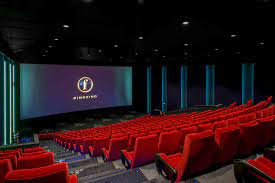

In [89]:
socket.setdefaulttimeout(30)

wd = webdriver.Chrome('chromedriver', options=chrome_options)
scraped_count = 0

path = "./"
query = input("검색어 입력: ")

dir_name = path + query
os.makedirs(dir_name)
print(f"[{dir_name} 디렉토리 생성]")

scraping(dir_name, query)
filter_and_remove(dir_name, query, 224)


In [90]:
#!rm -rf 'screen'
!cp -r '/content/cinema screens' /content/drive/MyDrive/screens

